In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/philippe/MolGenDocking


/home/philippe/miniconda3/envs/MolGen/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Loading

In [2]:
from pathlib import Path
import json
import re

import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import roc_curve, roc_auc_score
from mol_gen_docking.evaluation.diversity_aware_top_k import diversity_aware_top_k
from notebooks.utils import *

FIG_PATH = "MolGenDocking-latex/Figures/Results/Synthesis"
os.makedirs(FIG_PATH, exist_ok=True)


In [3]:
MOLSTRAL_PATH = Path("MolGenOutput/synthesis")

files = [f for d in MOLSTRAL_PATH.iterdir() for f in d.iterdir() if "error" not in str(f)]
files = sorted(files)

full_df = load_synth_results(files)

100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


In [5]:
full_df

,prompt_id,reward,model,prop_valid,validity,target,tanim_sim,Model
0,synth989,0.0,RL-Mistral-24B,0.0,False,COc1ccc(-c2ccc(C(=O)c3c(F)ccc(O)c3F)s2)cc1,0.0,RL-Mistral-24
1,synth989,0.0,RL-Mistral-24B,0.0,False,COc1ccc(-c2ccc(C(=O)c3c(F)ccc(O)c3F)s2)cc1,0.0,RL-Mistral-24
2,synth989,0.0,RL-Mistral-24B,0.0,False,COc1ccc(-c2ccc(C(=O)c3c(F)ccc(O)c3F)s2)cc1,0.0,RL-Mistral-24
3,synth989,0.0,RL-Mistral-24B,0.0,False,COc1ccc(-c2ccc(C(=O)c3c(F)ccc(O)c3F)s2)cc1,0.0,RL-Mistral-24
4,synth989,0.0,RL-Mistral-24B,0.0,False,COc1ccc(-c2ccc(C(=O)c3c(F)ccc(O)c3F)s2)cc1,0.0,RL-Mistral-24
...,...,...,...,...,...,...,...,...
39995,synth884,0.0,RL-Mistral-24B,0.0,False,COc1ccc2c(C(=O)NC(C)[C@H]3CCCN3C(=O)C3CCC(=O)C...,0.0,RL-Mistral-24
39996,synth884,0.0,RL-Mistral-24B,0.0,False,COc1ccc2c(C(=O)NC(C)[C@H]3CCCN3C(=O)C3CCC(=O)C...,0.0,RL-Mistral-24
39997,synth884,0.0,RL-Mistral-24B,0.0,False,COc1ccc2c(C(=O)NC(C)[C@H]3CCCN3C(=O)C3CCC(=O)C...,0.0,RL-Mistral-24
39998,synth884,0.0,RL-Mistral-24B,0.0,False,COc1ccc2c(C(=O)NC(C)[C@H]3CCCN3C(=O)C3CCC(=O)C...,0.0,RL-Mistral-24


<Axes: xlabel='Model', ylabel='Count'>

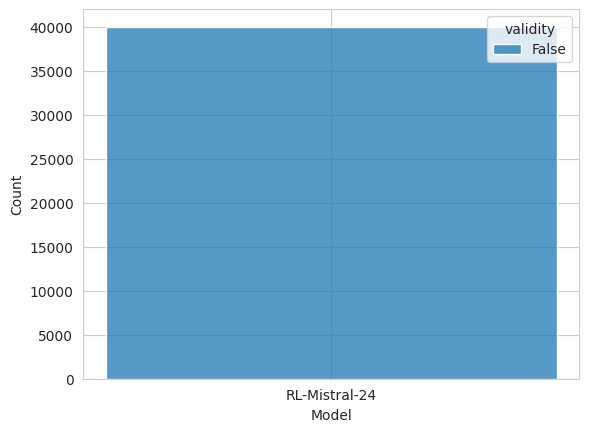

In [6]:
# Plot validity
sns.histplot(data=full_df, x="Model", hue="validity", multiple="stack")

# Metric Computation

## Regression

In [35]:
# Compute Spearman_corr
df = full_df[full_df.objectives == "regression"]



def get_yagg(values):
    values = [v for v in values if v != "invalid"]
    if len(values) == 0:
        return np.nan
    return np.mean(values)

df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)
correlations = df[df.validity == 1].groupby(["Model", "Task"])[["gt", "y_agg"]].corr(method="spearman").loc[pd.IndexSlice[:, :, "gt"], "y_agg"]
correlations = correlations.reset_index(level=2, drop=True)

coverage = df.groupby(["Model", "Task"]).validity.mean()

corr_cov_score = (correlations+1) * coverage / 2
corr_cov_score.fillna(0, inplace=True)

/tmp/ipykernel_19503/279605747.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)


In [36]:
corr_cov_score

Model      Task             
ChemDFM-R  antiviral-potency    0.608981
           az-logd              0.857419
           az-ppb-clearance     0.127953
           caco2                0.633325
           cyp3a4-novartis      0.611825
                                  ...   
gemma-3    ld50                 0.126472
           lipophilicity        0.631754
           mic-clearance-az     0.542018
           solubility           0.166507
           vdss                 0.535786
Length: 144, dtype: float64

## Classification

In [37]:
df = full_df[full_df.objectives == "classification"]

def get_yagg(values):
    values = [v for v in values if v != "invalid"]
    if len(values) == 0:
        return np.nan
    return np.round(np.mean(values))

df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)
accuracy = df.groupby(["Model", "Task"])[["gt", "y_agg"]].apply(lambda x: np.nanmean(x["gt"].to_numpy() == x["y_agg"].to_numpy()))

/tmp/ipykernel_19503/2770724304.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_agg"] = df.groupby(["Model", "prompt_id"]).y.transform(get_yagg)


## Add to table

In [38]:
# Join regression metrics
reg_metric = corr_cov_score.reset_index().rename(columns={0: "Metric"})
cls_metric = accuracy.reset_index().rename(columns={0: "Metric"})

full_df = full_df.drop(columns=["Metric"], errors="ignore")
full_df = full_df.merge(
    pd.concat([reg_metric, cls_metric]),
    on=["Model", "Task"],
    how="left"
)


# Plots

In [39]:
KEY = "Metric"
table = full_df.groupby(["Model", "Task", "objectives"])[KEY].mean().reset_index()
MODEL_ORDER = list(CMAP_MODELS.keys())

task_order = table.groupby(["Model", "Task"])[KEY].mean().reset_index().groupby("Task")[KEY].max().sort_values( ascending=False).index

table = table.set_index(["Task"]).loc[task_order].reset_index()
table

,Task,Model,objectives,Metric
0,az-logd,ChemDFM-R,regression,0.857419
1,az-logd,Llama-3.3,regression,0.196332
2,az-logd,Qwen3-Think.,regression,0.287881
3,az-logd,R1-Llama,regression,0.330029
4,az-logd,R1-Qwen,regression,0.371524
...,...,...,...,...
211,fang-solubility,R1-Llama,regression,0.296958
212,fang-solubility,R1-Qwen,regression,0.285160
213,fang-solubility,RL-Mistral,regression,0.434603
214,fang-solubility,ether0,regression,0.020059


# Heatmap

In [40]:
MODEL_ORDER = full_df[full_df.objectives == "regression"].groupby("Model")[KEY].mean().sort_values().index.tolist()

In [41]:
def plot_heatmap(table, axes, title_name, split_val, vmin=0, vmax=1):
    ax = axes[0]
    pivoted = pd.pivot_table(table[table.objectives == split_val], KEY, "Model", "Task")
    col_order = pivoted.max().sort_values(ascending=False).index
    pivoted = pivoted.loc[MODEL_ORDER,col_order]
    sns.heatmap(
        pivoted,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 8}
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(rotation=90, ha='center', labels=ax.get_xticklabels())
    ax.set_title(title_name)

    ax = axes[1]
    pivoted = pd.pivot_table(table[table.objectives == split_val], KEY, "Model", "objectives")
    pivoted = pivoted.loc[MODEL_ORDER]
    sns.heatmap(
        pivoted,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 8}
    )
    ax.set_xlabel("")
    ax.set_xticklabels(rotation=90, ha='center', labels=["Avg."])
    ax.set_title(f"Avg.\n{title_name}")


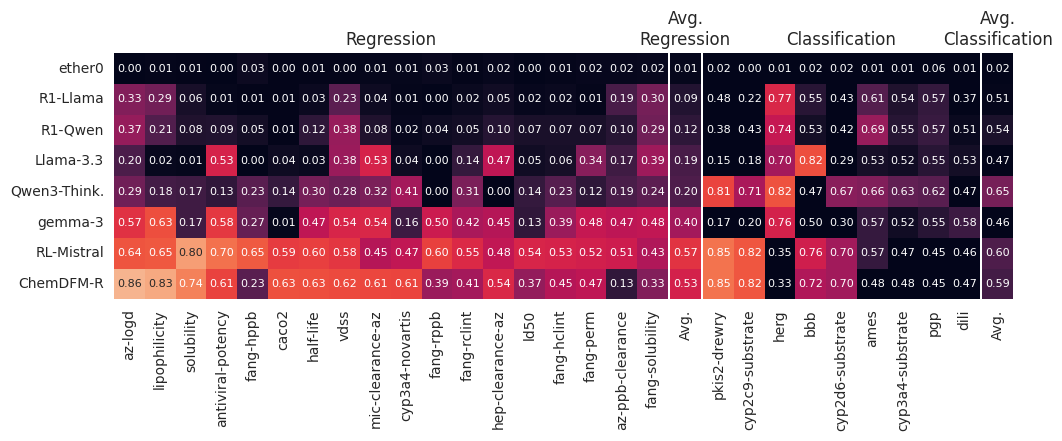

In [42]:
n_tot_cols = table.Task.nunique() + 2
n_rows = table.Model.nunique()

reg_ratio = table[table.objectives == "regression"].Task.nunique() / n_tot_cols
cls_ratio = table[table.objectives == "classification"].Task.nunique() / n_tot_cols

fig, axes = plt.subplots(
    1,
    4,
    figsize = (0.4*n_tot_cols,0.4 * n_rows),
    sharey=True,
    gridspec_kw = {
        "width_ratios":[reg_ratio, 1/n_tot_cols, cls_ratio,  1/n_tot_cols],
        "wspace":0.01,
    }
)

plot_heatmap(table, [axes[0],axes[1]], "Regression", "regression")
plot_heatmap(table, [axes[2],axes[3]], "Classification", "classification", vmin = 0.5, vmax=1)

for ax in axes[1:]:
    ax.set_ylabel("")

fig.savefig(f"{FIG_PATH}/molecular_proppred_heatmap.pdf", bbox_inches="tight")

In [24]:
LATEX_PATH = "/home/philippe/-Philippe-MolGenDocking/tables"

In [25]:
formatter = PandasTableFormatter(
    n_decimals = 3, # Number of decimals to keep in the table
    aggregation_methods=["mean"], # Aggregation functions to apply to the data
    main_subset=0, # Subset of values to bold, here the first column will be bolded corresponding to the mean values, if [0,1] the first two columns will be bolded (independently)
    hide_agg_labels=True, # Hide the aggregation column names in the latex
    global_agg=False # Whether to compute global aggregation across all columns (True)
)

style = formatter.style(
    table, # Dataframe to format
    rows= ["Model", "Size", "Think."], # Rows
    cols="Task", # Columns
    values= KEY, # Values
    highlight_fn= np.nanmax, # Function to use to highlight the values, here the maximum values will be highlighted
    props=["font-weight: bold; text-decoration: underline;"], # Properties to apply to the highlighted values, here the maximum values will be underlined and bolded, the second maximum values will be bolded
    special_format_agg = {
        "std": lambda x: "\\tiny $\\pm$" + x, # Format to apply to the standard deviation values
    },
    remove_col_names=False,
    # row_order = MODEL_ORDER
)
style

KeyError: 'Size'

In [ ]:
formatter.save_to_latex(style, f"{LATEX_PATH}/gen_table.tex", 1, multicol_align="|c|", hrules=True, n_first_cols=2)
style